loading dataset refcoco+ into memory...
creating index...
index created.
done
49856
19992
19992
There are 42278 training referred objects.
Namespace(acc_bn=False, activation='lrelu', arch_option=0, aux=False, backbone='clip_vitl16_384', base_size=520, batch_size=16, block_depth=0, crop_size=480, cuda=True, data_path='../datasets/', dataset='ade20k', eval=False, export=None, ignore_index=-1, label_src='default', model='encnet', module='lseg', no_cuda=False, no_val=False, scale_inv=True, se_loss=False, se_weight=0.2, seed=1, test_batch_size=16, test_val=False, train_split='train', weights='', widehead=False, widehead_hr=False, workers=16)
** Use norm [0.5, 0.5, 0.5], [0.5, 0.5, 0.5] as the mean and std **
{'base_size': 520, 'crop_size': 480}
train
BaseDataset: base_size 520, crop_size 480
len(img_paths): 20210
val
MultiEvalModule: base_size 520, crop_size 480
{'ann_id': 1719310,
 'category_id': 1,
 'file_name': 'COCO_train2014_000000581857_16.jpg',
 'image_id': 581857,
 'ref_id': 0,
 'se

C:\Users\bater\anaconda3\envs\lseg37\lib\site-packages\torch\nn\functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


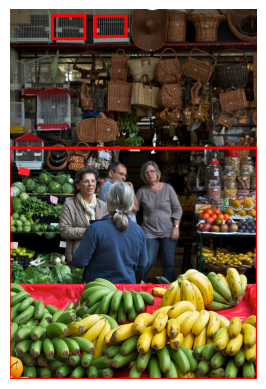

In [3]:
import sys
refer_path = "D:\\Datasets\\refer-master\\refer-master"
img_path = refer_path+"\\data\\images\\mscoco\\images\\train2014\\"
sys.path.append(refer_path)
from refer import REFER
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pprint import pprint
import csv
import cv2
# IoU function
def computeIoU(box1, box2):
    # each box is of [x1, y1, w, h]
    inter_x1 = max(box1[0], box2[0])
    inter_y1 = max(box1[1], box2[1])
    inter_x2 = min(box1[0]+box1[2]-1, box2[0]+box2[2]-1)
    inter_y2 = min(box1[1]+box1[3]-1, box2[1]+box2[3]-1)

    if inter_x1 < inter_x2 and inter_y1 < inter_y2:
        inter = (inter_x2-inter_x1+1)*(inter_y2-inter_y1+1)
    else:
        inter = 0
    union = box1[2]*box1[3] + box2[2]*box2[3] - inter
    return float(inter)/union
    
    
data_root = refer_path + '/data'  # contains refclef, refcoco, refcoco+, refcocog and images
dataset = 'refcoco+'
splitBy = 'unc'
refer = REFER(data_root, dataset, splitBy)


ref_ids = refer.getRefIds()
print(len(ref_ids))
print (len(refer.Imgs))
print (len(refer.imgToRefs))

ref_ids = refer.getRefIds(split='train')
print ('There are %s training referred objects.' % len(ref_ids))

#initialize LSeg
import os
import argparse
import numpy as np
from tqdm import tqdm
from collections import OrderedDict

import torch
import torch.nn.functional as F
from torch.utils import data
import torchvision.transforms as transform
from torch.nn.parallel.scatter_gather import gather

import encoding.utils as utils
from encoding.nn import SegmentationLosses, SyncBatchNorm
from encoding.parallel import DataParallelModel, DataParallelCriterion
from encoding.datasets import test_batchify_fn 
from encoding.models.sseg import BaseNet
from additional_utils.models import LSeg_MultiEvalModule
from modules.lseg_module import LSegModule

import math
import types
import functools
import torchvision.transforms as torch_transforms
import copy
import itertools
from PIL import Image
import matplotlib.pyplot as plt
import clip
import matplotlib as mpl
import matplotlib.colors as mplc
import matplotlib.figure as mplfigure
import matplotlib.patches as mpatches
from matplotlib.backends.backend_agg import FigureCanvasAgg
from data import get_dataset
import torchvision.transforms as transforms

class Options:
    def __init__(self):
        parser = argparse.ArgumentParser(description="PyTorch Segmentation")
        # model and dataset
        parser.add_argument(
            "--model", type=str, default="encnet", help="model name (default: encnet)"
        )
        parser.add_argument(
            "--backbone",
            type=str,
            default="clip_vitl16_384",
            help="backbone name (default: resnet50)",
        )
        parser.add_argument(
            "--dataset",
            type=str,
            default="ade20k",
            help="dataset name (default: pascal12)",
        )
        parser.add_argument(
            "--workers", type=int, default=16, metavar="N", help="dataloader threads"
        )
        parser.add_argument(
            "--base-size", type=int, default=520, help="base image size"
        )
        parser.add_argument(
            "--crop-size", type=int, default=480, help="crop image size"
        )
        parser.add_argument(
            "--train-split",
            type=str,
            default="train",
            help="dataset train split (default: train)",
        )
        parser.add_argument(
            "--aux", action="store_true", default=False, help="Auxilary Loss"
        )
        parser.add_argument(
            "--se-loss",
            action="store_true",
            default=False,
            help="Semantic Encoding Loss SE-loss",
        )
        parser.add_argument(
            "--se-weight", type=float, default=0.2, help="SE-loss weight (default: 0.2)"
        )
        parser.add_argument(
            "--batch-size",
            type=int,
            default=16,
            metavar="N",
            help="input batch size for \
                            training (default: auto)",
        )
        parser.add_argument(
            "--test-batch-size",
            type=int,
            default=16,
            metavar="N",
            help="input batch size for \
                            testing (default: same as batch size)",
        )
        # cuda, seed and logging
        parser.add_argument(
            "--no-cuda",
            action="store_true",
            default=False,
            help="disables CUDA training",
        )
        parser.add_argument(
            "--seed", type=int, default=1, metavar="S", help="random seed (default: 1)"
        )
        # checking point
        parser.add_argument(
            "--weights", type=str, default='', help="checkpoint to test"
        )
        # evaluation option
        parser.add_argument(
            "--eval", action="store_true", default=False, help="evaluating mIoU"
        )
        parser.add_argument(
            "--export",
            type=str,
            default=None,
            help="put the path to resuming file if needed",
        )
        parser.add_argument(
            "--acc-bn",
            action="store_true",
            default=False,
            help="Re-accumulate BN statistics",
        )
        parser.add_argument(
            "--test-val",
            action="store_true",
            default=False,
            help="generate masks on val set",
        )
        parser.add_argument(
            "--no-val",
            action="store_true",
            default=False,
            help="skip validation during training",
        )

        parser.add_argument(
            "--module",
            default='lseg',
            help="select model definition",
        )

        # test option
        parser.add_argument(
            "--data-path", type=str, default='../datasets/', help="path to test image folder"
        )

        parser.add_argument(
            "--no-scaleinv",
            dest="scale_inv",
            default=True,
            action="store_false",
            help="turn off scaleinv layers",
        )

        parser.add_argument(
            "--widehead", default=False, action="store_true", help="wider output head"
        )

        parser.add_argument(
            "--widehead_hr",
            default=False,
            action="store_true",
            help="wider output head",
        )
        parser.add_argument(
            "--ignore_index",
            type=int,
            default=-1,
            help="numeric value of ignore label in gt",
        )
        
        parser.add_argument(
            "--label_src",
            type=str,
            default="default",
            help="how to get the labels",
        )
        
        parser.add_argument(
            "--arch_option",
            type=int,
            default=0,
            help="which kind of architecture to be used",
        )

        parser.add_argument(
            "--block_depth",
            type=int,
            default=0,
            help="how many blocks should be used",
        )

        parser.add_argument(
            "--activation",
            choices=['lrelu', 'tanh'],
            default="lrelu",
            help="use which activation to activate the block",
        )

        self.parser = parser

    def parse(self):
        args = self.parser.parse_args(args=[]) 
        args.cuda = not args.no_cuda and torch.cuda.is_available()
        print(args)
        return args
    


# If image path and f/q is not passed as command
# line arguments, quit and display help message
#if len(sys.argv) < 3:
#    print(__doc__)
#    sys.exit(1)
def ssearch(img_path, bbox, min_size):
    print(min_size)
    rects = []
    # speed-up using multithreads
    cv2.setUseOptimized(True);
    cv2.setNumThreads(4);
    top_left = (bbox[0],bbox[1])
    # read image
    im = cv2.imread(img_path)[bbox[1]:bbox[3],bbox[0]:bbox[2]]
    #cv2.imshow("test", im)
    #print(im)

    # create Selective Search Segmentation Object using default parameters
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

    # set input image on which we will run segmentation
    ss.setBaseImage(im)


    #ss.switchToSelectiveSearchQuality()
    ss.switchToSelectiveSearchFast()

    # run selective search segmentation on input image
    temp_rects = ss.process() #xywh
    for rect in temp_rects:
        if boxSize_xywh(rect)>min_size: #remove box if too small
            temp_rect = [0,0,0,0]
            temp_rect[0] = rect[0]+top_left[0]
            temp_rect[1] = rect[1]+top_left[1]
            temp_rect[2] = temp_rect[0]+rect[2]
            temp_rect[3] = temp_rect[1]+rect[3]
            rects.append(temp_rect)
    print('Total Number of Region Proposals: {}'.format(len(rects)))


    # number of region proposals to show
    numShowRects = 100
    # increment to increase/decrease total number
    # of reason proposals to be shown
    increment = 50
    return rects
    
    
def get_new_pallete(num_cls):
    n = num_cls
    pallete = [0]*(n*3)
    for j in range(0,n):
            lab = j
            pallete[j*3+0] = 0
            pallete[j*3+1] = 0
            pallete[j*3+2] = 0
            i = 0
            while (lab > 0):
                    pallete[j*3+0] |= (((lab >> 0) & 1) << (7-i))
                    pallete[j*3+1] |= (((lab >> 1) & 1) << (7-i))
                    pallete[j*3+2] |= (((lab >> 2) & 1) << (7-i))
                    i = i + 1
                    lab >>= 3
    return pallete

def get_new_mask_pallete(npimg, new_palette, out_label_flag=False, labels=None):
    """Get image color pallete for visualizing masks"""
    # put colormap
    out_img = Image.fromarray(npimg.squeeze().astype('uint8'))
    out_img.putpalette(new_palette)

    if out_label_flag:
        assert labels is not None
        u_index = np.unique(npimg)
        patches = []
        for i, index in enumerate(u_index):
            label = labels[index]
            cur_color = [new_palette[index * 3] / 255.0, new_palette[index * 3 + 1] / 255.0, new_palette[index * 3 + 2] / 255.0]
            red_patch = mpatches.Patch(color=cur_color, label=label)
            patches.append(red_patch)
    return out_img, patches

#Draw Rectangle on input canvas
def draw_rectangle(draw, coordinates, color, width=1):
    for i in range(width):
        rect_start = (coordinates[0][0] - i, coordinates[0][1] - i)
        rect_end = (coordinates[1][0] + i, coordinates[1][1] + i)
        draw.rectangle((rect_start, rect_end), outline = color)
#Compare if pixel A and B are the same, return true if same
def comparePixel(pxA,pxB):
    for i in range(len(pxA)):
       # print(type(pxA))
       # print(type(pxB))
        if pxA[i] != pxB[i]:
            return False
    return True

#Convert the palette used in lseg into rgba for easier computation
def palette_to_rgba(new_palette):
    colors = [] 
    for i in range(2,len(new_palette),3): #new_pallete is a contiguous tuple of rgb values
        colors.append([new_palette[i-2],new_palette[i-1],new_palette[i]])
    rgba_cols = []
    for color in colors:
        color.append(255)
        rgba_cols.append(np.array(color))
    return rgba_cols #colors of each label for the segmap
#Break the singular segmap into multiple maps for each input label, and generate a single bounding box for each label
#Each generated segmap will have transparency for pixels that are not of the label
def process_segmap(rgba_cols, seg):
    bboxes = []
    segmaps = []

    for rgba_col in rgba_cols:
        test_seg = np.array(seg).copy()
        xmin = ymin = 99999
        xmax = ymax = 0
        #separate the segments, put in a larger loop for each label
        for col in range(0,len(test_seg)):
            #print(row)
            for row in range(0,len(test_seg[col])):
                if not comparePixel(test_seg[col][row],rgba_col):
                    test_seg[col][row] = [0,0,0,0] #make transparent
                else: #get top left and bottom right to draw rectangle
                    if row>xmax:
                        xmax = row
                    if col>ymax:
                        ymax = col
                    if row<xmin:
                        xmin = row
                    if col<ymin:
                        ymin = col
        bboxes.append([xmin,ymin,xmax,ymax])
        segmaps.append(test_seg)
    return bboxes, segmaps
    #Image.fromarray(test_seg)
    
#Function to find the gap within the existing bounding box
#Returns 2 arrays indicating the range or horizontal gap and vertical gap
#Values in the array can be used to identify how to split the bounding boxes
#Eg. Return value [sx1,sx2] indicates the split starts from x=sx1, y=y and ends at x=sx2, y=y

def contiguous_transparency_scan(box,segmap,instance_threshold=0):
    #iterative vertical scan (left to right scan every column)
    min_x = max_x = -1
    for x in range(box[0],box[2]):
        isContiguous = True #whether it is a contiguous transparent block
        count_colored = 0
        for y in range(box[1],box[3]):
            #print(x,y)
            if not comparePixel(segmap[y][x],[0,0,0,0]):
                count_colored+=1
                if count_colored>instance_threshold:
                    isContiguous = False
                    break
        if isContiguous:
            #print(x)
            if min_x==-1:
                min_x = x
                max_x = min_x
            else:
                max_x +=1
        else:
            if max_x - min_x > 0:
                break
    #iterative horizontal scan (top to bottom scan every row)
    min_y = max_y = -1
    for y in range(box[1],box[3]):
        isContiguous = True
        count_colored = 0
        for x in range(box[0],box[2]):
            if not comparePixel(segmap[y][x],[0,0,0,0]):
                count_colored+=1
                if count_colored>=instance_threshold:
                    isContiguous = False
                    break
                #isContiguous = False
                #break
        if isContiguous:
            if min_y==-1:
                min_y = y
                max_y = min_y
            else:
                max_y +=1
        else:
            if max_y - min_y > 0:
                break
    #if max_x - min_x>0 or arbitary threshold means there is a gap in the segmentation
    # if the above is true, that means the bounding box can be instanced into a left and right instance
    # if max_y - min_y >0 or arbitary threshold, means thee boundingbox can be instanced into a top and bottom instance
    return [min_x,max_x],[min_y,max_y]

#Optimize the new boxes to fit nicely around the segment instance, split bounding boxes tend to be larger than segment
def optimizeBoxes(bbox,segmap):
    new_boxes = []

    for box in bbox:
        xmin = ymin = 99999
        xmax = ymax = 0
        for col in range(box[0],box[2]):
            for row in range(box[1],box[3]):
                if not comparePixel(segmap[row][col], [0,0,0,0]):
                    if col>xmax:
                        xmax = col
                    if row>ymax:
                        ymax = row
                    if col<xmin:
                        xmin = col
                    if row<ymin:
                        ymin = row
        if [xmin,ymin,xmax,ymax] != [99999,99999,0,0]:
            new_boxes.append([xmin,ymin,xmax,ymax])
        else:
            new_boxes.append(box)

    return new_boxes

#Split boxes and optimize
def splitBox(box,x_split, y_split, segmap):
    bbox = []
    if x_split[0]==-1 and y_split[0]==-1:
        return
    elif x_split[0]==-1:
        #splt top and bottom
        top_box = [box[0],y_split[0],box[2],box[3]]
        bot_box = [box[0],box[1],box[2],y_split[1]]
        #bbox = [top_box,bot_box]
        bbox = optimizeBoxes([top_box,bot_box],segmap)
    else:
        #split left and right
        left_box = [box[0],box[1],x_split[0],box[3]]
        right_box = [x_split[1],box[1],box[2],box[3]]
        #bbox = [left_box,right_box]
        bbox = optimizeBoxes([left_box,right_box],segmap)
    return bbox
    
#Return box size in area
def boxSize(box):
    x = box[2]-box[0]
    y = box[3]-box[1]
    return x*y

def boxSize_xywh(box):
    return box[2]*box[3]
    
#Return max similarity value for each variable
def boxSimilarity(box1,box2):
    x1 = abs(box2[0]-box1[0])
    y1 = abs(box2[1]-box1[1])
    x2 = abs(box2[2]-box1[2])
    y2 = abs(box2[3]-box1[3])
    return max([x1,y1,x2,y2])
    
#Main function to instance the segmentation map based on horizontal and verticle gaps, as well as optimize the size
#boxes that are too similar or too small are also filtered out along the way
def bbox_instancing(bboxes,segmaps,min_size = 5):
    final_instances = []
    for idx in range(len(bboxes)): #number of classes
        box = bboxes[idx]
        segmap = segmaps[idx]

        box_instances = []
        instanced_boxes = [box]
        i = 0
        #iteratively instance boxes repeatedly until boxes cannot be instanced further
        while(i<len(instanced_boxes)):
            x_contiguous,y_contiguous = contiguous_transparency_scan(instanced_boxes[i],segmap,instance_threshold=0)
            #x_contiguous,y_contiguous = segmap_instancing(instanced_boxes[i],segmap,instance_threshold=0)
            #print (x_contiguous)
            new_bboxes = splitBox(instanced_boxes[i],x_contiguous,y_contiguous,segmap)
            #print(new_bboxes)
            if new_bboxes != None:
                new_count = 0
                instanced_boxes.pop(i) #remove the box that got split into 2 instances first
                i-=1
                for new_box in new_bboxes:
                    #append the instances only if it meets the minimum size requirement
                    if boxSize(new_box)>min_size:
                        instanced_boxes.append(new_box)
                        new_count+=1
                #if new_count>0: #if at least one new box is added

            i+=1
        #filter out similar boxes that are adjacent
        i=0
        while(i<len(instanced_boxes)-1):

            sim = boxSimilarity(instanced_boxes[i],instanced_boxes[i+1])
            if (sim<5): #too similar
                #print(instanced_boxes[i],instanced_boxes[i+1])
                # remove smaller box
                if boxSize(instanced_boxes[i])>boxSize(instanced_boxes[i+1]):
                    instanced_boxes.pop(i+1)
                else:
                    instanced_boxes.pop(i)
                i-=1
            i+=1
        final_instances.append(instanced_boxes)
    return final_instances
    
args = Options().parse()

torch.manual_seed(args.seed)
args.test_batch_size = 1 
alpha=0.5
    
args.scale_inv = False
args.widehead = True
args.dataset = 'ade20k'
args.backbone = 'clip_vitl16_384'
args.weights = 'checkpoints/demo_e200.ckpt'
args.ignore_index = 255

module = LSegModule.load_from_checkpoint(
    checkpoint_path=args.weights,
    data_path=args.data_path,
    dataset=args.dataset,
    backbone=args.backbone,
    aux=args.aux,
    num_features=256,
    aux_weight=0,
    se_loss=False,
    se_weight=0,
    base_lr=0,
    batch_size=1,
    max_epochs=0,
    ignore_index=args.ignore_index,
    dropout=0.0,
    scale_inv=args.scale_inv,
    augment=False,
    no_batchnorm=False,
    widehead=args.widehead,
    widehead_hr=args.widehead_hr,
    map_locatin="cpu",
    arch_option=0,
    block_depth=0,
    activation='lrelu',
)

input_transform = module.val_transform

# dataloader
loader_kwargs = (
    {"num_workers": args.workers, "pin_memory": True} if args.cuda else {}
)

# model
if isinstance(module.net, BaseNet):
    model = module.net
else:
    model = module
    
model = model.eval()
model = model.cpu()
scales = (
    [0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25]
    if args.dataset == "citys"
    else [0.5, 0.75, 1.0, 1.25, 1.5, 1.75]
)  

model.mean = [0.5, 0.5, 0.5]
model.std = [0.5, 0.5, 0.5]

evaluator = LSeg_MultiEvalModule(
    model, scales=scales, flip=True
).cuda()
evaluator.eval()



#initialize CLIP

import clip

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

counter = 0
checkpoint = 0 # enter last index in iou log

#loop

In [16]:
ref_id = ref_ids[1]
#if counter<=(checkpoint+2): #somehow need to add +2 to checkpoint to resume
#    counter+=1
#    continue
ref = refer.loadRefs(ref_id)[0]
image_id = refer.getImgIds(ref_id)[0]
#if len(ref['sentences']) < 2:
#    continue

pprint(ref)
print ('LSeg label %s.' % refer.Cats[ref['category_id']]) #pass to lseg
args.label_src = refer.Cats[ref['category_id']] + ",others"

#LSEG Running
labels = []
print('** Input label value: {} **'.format(args.label_src))
lines = args.label_src.split(',')
for line in lines:
    label = line
    labels.append(label)
#labels.append("others")

#try:
#load image
#crop_size = 480
padding = [0.0] * 3
image = Image.open(img_path+refer.loadImgs(image_id)[0]['file_name'])
#plt.imshow(image)
image = np.array(image)
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)
image = transform(image).unsqueeze(0)
img = image[0].permute(1,2,0)
img = img * 0.5 + 0.5
#plt.imshow(img)


with torch.no_grad():
    outputs = evaluator.parallel_forward(image, labels) #evaluator.forward(image, labels) #parallel_forward
    #outputs = model(image,labels)
    predicts = [
        torch.max(output, 1)[1].cpu().numpy() 
        for output in outputs
    ]
#Lseg results    
predict = predicts[0]

new_palette = get_new_pallete(len(labels))
mask, patches = get_new_mask_pallete(predict, new_palette, out_label_flag=True, labels=labels)
img = image[0].permute(1,2,0)
img = img * 0.5 + 0.5
img = Image.fromarray(np.uint8(255*img)).convert("RGBA")
seg = mask.convert("RGBA")
out = Image.blend(img, seg, alpha)
#plt.axis('off')
#plt.imshow(img)
#plt.figure()
#plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
#plt.axis('off')
#plt.imshow(seg)

#get bbox
rgba_cols = palette_to_rgba(new_palette)
bboxes, segmaps = process_segmap(rgba_cols,seg)

#Show results of bounding boxes
from PIL import Image, ImageDraw
img_copy = img.copy()
#for i in range(0,len(bboxes)-1):
#    topLeft = (bboxes[i][0],bboxes[i][1])
#    bottomRight = (bboxes[i][2],bboxes[i][3])
#    img1 = ImageDraw.Draw(img_copy)
#    rect_color = getHexColor(rgba_cols[i])
#    draw_rectangle(img1, (topLeft,bottomRight),color = tuple(rgba_cols[i]), width=5)
#plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
#plt.axis('off')
#plt.imshow(img_copy)

w,h = img.size
min_size = w*h*0.005 #arbitary min size, 0.005 for the cat human image
new_bbox = bbox_instancing(bboxes,segmaps,min_size=min_size) 

#sample bbox instancing result
img_copy_test = img.copy()
for i in range(len(new_bbox)-1):
    for j in range(len(new_bbox[i])):
        topLeft = (new_bbox[i][j][0],new_bbox[i][j][1])
        bottomRight = (new_bbox[i][j][2],new_bbox[i][j][3])
        img1 = ImageDraw.Draw(img_copy_test)
        #rect_color = getHexColor(rgba_cols[i])
        draw_rectangle(img1, (topLeft,bottomRight),color = "red", width=5)
        #draw_rectangle(img1, (topLeft,bottomRight),color = "red", width=2)
#plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
#plt.axis('off')
#plt.imshow(img_copy_test)
img_copy_clip = Image.open(img_path+refer.loadImgs(image_id)[0]['file_name'])
img_copy_clip = np.array(img_copy_clip)
cropped_imgs = []
for class_bbox in new_bbox:
    cropped_imgs.append([])
    for bbox in class_bbox:
        cropped_imgs[len(cropped_imgs)-1].append(img_copy_clip[bbox[1]:bbox[3],bbox[0]:bbox[2]])



for cls in cropped_imgs:
    for i in range(len(cls)):
        #img_transform = transform(cls[i]).unsqueeze(0)
        #print(cls[i])
        cls[i]=Image.fromarray(cls[i])


vote_arr = [0]*len(new_bbox[0])

for sentence in ref['sentences']:          
    max_score = 0
    best_id = -1
    ret_index_temp = []
    ret_index_cls = []
    #print("number of cropped: "+ str(len(cropped_imgs[0])))
    for j in range(len(cropped_imgs[0])): #for each cropped_image run it through clip with the label of description and get the highest scoring boxes
        #image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)
        image = preprocess(cropped_imgs[0][j]).unsqueeze(0).to(device)
        #text = clip.tokenize(["person in blue", "person in white", "person in red"]).to(device)
        text = clip.tokenize([sentence['sent'], "other"]).to(device)  #extracted input is also based on class
        with torch.no_grad():
            image_features = model.encode_image(image)
            text_features = model.encode_text(text)

            logits_per_image, logits_per_text = model(image, text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()

        #print("Box "+str(j)+": "+str(probs[0][0]))
        #if score is higher than max, max = score and append to list. if score within 0.1 of max score, append as well
        if probs[0][0]>max_score:
            max_score = probs[0][0]
            best_id = j
    vote_arr[best_id]+=1

#print(vote_arr)
best_bbox = vote_arr.index(max(vote_arr)) #narrow down 1 box in the instance first, then use region proposal within that box

{'ann_id': 463958,
 'category_id': 1,
 'file_name': 'COCO_train2014_000000581857_0.jpg',
 'image_id': 581857,
 'ref_id': 1,
 'sent_ids': [3, 4, 5],
 'sentences': [{'raw': 'grey shirt wearing glasses',
                'sent': 'gray shirt wearing glasses',
                'sent_id': 3,
                'tokens': ['gray', 'shirt', 'wearing', 'glasses']},
               {'raw': 'lady with glasses',
                'sent': 'lady with glasses',
                'sent_id': 4,
                'tokens': ['lady', 'with', 'glasses']},
               {'raw': 'woman with grey shirt standing next to man',
                'sent': 'woman with gray shirt standing next to man',
                'sent_id': 5,
                'tokens': ['woman',
                           'with',
                           'gray',
                           'shirt',
                           'standing',
                           'next',
                           'to',
                           'man']}],
 'split': 'train'

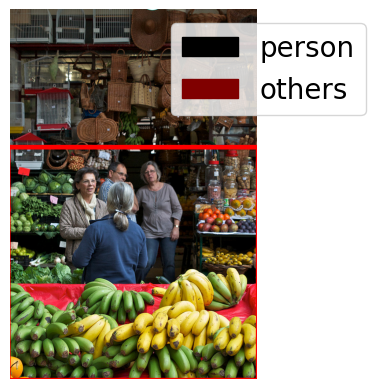

In [17]:
#draw results from clip
from PIL import Image, ImageDraw
img_copy_test2 = img.copy()
#print("clip retval: " + str(best_bbox))
#print((processed_new_bbox[i][j]))
topLeft = (new_bbox[0][best_bbox][0],new_bbox[0][best_bbox][1])
bottomRight = (new_bbox[0][best_bbox][2],new_bbox[0][best_bbox][3])
img2 = ImageDraw.Draw(img_copy_test2)
#rect_color = getHexColor(rgba_cols[i])
draw_rectangle(img2, (topLeft,bottomRight),color = "red", width=8)
new_bbox_xywh = [topLeft[0], topLeft[1], bottomRight[0]-topLeft[0], bottomRight[1]-topLeft[1]]
#ref_bbox = refer.refToAnn[ref_id]['bbox']
#IoU = computeIoU(ref_bbox, new_bbox_xywh)
#print("IoU:"+str(IoU))
#draw_rectangle(img1, (topLeft,bottomRight),color = "red", width=2)
plt.axis('off')
plt.imshow(img_copy_test2)
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})

In [18]:
#####REGION PROPOSAL########
prop_rects = ssearch(img_path+refer.loadImgs(image_id)[0]['file_name'], new_bbox[0][best_bbox], min_size) #uninstanced bboxes, use the best box and perform region proposal
img_copy_test = Image.open(img_path+refer.loadImgs(image_id)[0]['file_name'])
#print(prop_rects)
count = 0

best_bbox = -1

padding = [0.0] * 3
img_copy_clip = Image.open(img_path+refer.loadImgs(image_id)[0]['file_name'])
#print(type(img_copy_clip))
img_copy_clip = np.array(img_copy_clip)

cropped_imgs = [[]]


for bbox in prop_rects:
    #print(bbox)
    cropped_imgs[0].append(Image.fromarray(img_copy_clip[bbox[1]:bbox[3],bbox[0]:bbox[2]]))


vote_arr = []

best_id = -1

1366.4
Total Number of Region Proposals: 1437


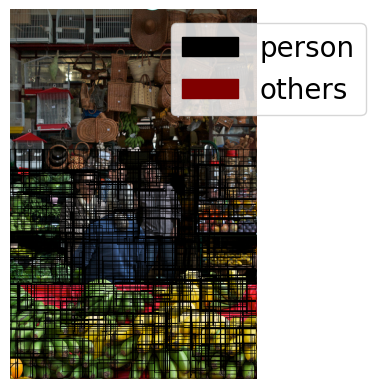

In [20]:

for rect in prop_rects:
    #print((processed_new_bbox[i][j]))
    topLeft = (rect[0],rect[1])
    bottomRight = (rect[2],rect[3])
    img1 = ImageDraw.Draw(img_copy_test)
    #rect_color = getHexColor(rgba_cols[i])
    draw_rectangle(img1, (topLeft,bottomRight),color = tuple(rgba_cols[0]), width=1)
    #draw_rectangle(img1, (topLeft,bottomRight),color = "red", width=2)
    count+=1
    if count>1000:
        break
plt.axis('off')
plt.imshow(img_copy_test)
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
#print("Input: "+user_input)
#bboxes

In [21]:
for sentence in ref['sentences']:          
    max_score = 0
    ret_index_temp = []
    ret_index_cls = []
    #print("number of cropped: "+ str(len(cropped_imgs[0])))
    for j in range(len(cropped_imgs[0])): #for each cropped_image run it through clip with the label of description and get the highest scoring boxes
        #print(j)
        #image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)
        image = preprocess(cropped_imgs[0][j]).unsqueeze(0).to(device)
        #text = clip.tokenize(["person in blue", "person in white", "person in red"]).to(device)
        text = clip.tokenize([sentence['sent'], "other"]).to(device)  #extracted input is also based on class
        with torch.no_grad():
            image_features = model.encode_image(image)
            text_features = model.encode_text(text)

            logits_per_image, logits_per_text = model(image, text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()

        print("Box "+str(j)+": "+str(probs[0][0]))
        #if score is higher than max, max = score and append to list. if score within 0.1 of max score, append as well
        if probs[0][0]>max_score:
            max_score = probs[0][0]
            best_id = j
    if best_id not in vote_arr:
        vote_arr.append(best_id)
    else:
        break


Box 0: 0.003223
Box 1: 0.01772
Box 2: 0.154
Box 3: 0.8223
Box 4: 0.012054
Box 5: 0.01854
Box 6: 0.02676
Box 7: 0.02443
Box 8: 0.02162
Box 9: 0.4072
Box 10: 0.02556
Box 11: 0.396
Box 12: 0.00956
Box 13: 0.4417
Box 14: 0.07806
Box 15: 0.01001
Box 16: 0.0321
Box 17: 0.03964
Box 18: 0.85
Box 19: 0.03067
Box 20: 0.012054
Box 21: 0.3486
Box 22: 0.02802
Box 23: 0.01495
Box 24: 0.07056
Box 25: 0.07056
Box 26: 0.01169
Box 27: 0.3738
Box 28: 0.03677
Box 29: 0.03516
Box 30: 0.007935
Box 31: 0.00479
Box 32: 0.5234
Box 33: 0.01065
Box 34: 0.0637
Box 35: 0.05835
Box 36: 0.007347
Box 37: 0.001255
Box 38: 0.011246
Box 39: 0.1144
Box 40: 0.00701
Box 41: 0.02887
Box 42: 0.0526
Box 43: 0.002083
Box 44: 0.6406
Box 45: 0.02844
Box 46: 0.78
Box 47: 0.4883
Box 48: 0.2783
Box 49: 0.8105
Box 50: 0.03622
Box 51: 0.0575
Box 52: 0.01343
Box 53: 0.04602
Box 54: 0.01692
Box 55: 0.6826
Box 56: 0.05185
Box 57: 0.01692
Box 58: 0.002693
Box 59: 0.8633
Box 60: 0.03677
Box 61: 0.2847
Box 62: 0.02887
Box 63: 0.004757
Box 

Box 506: 0.02162
Box 507: 0.02002
Box 508: 0.7056
Box 509: 0.842
Box 510: 0.004135
Box 511: 0.01099
Box 512: 0.002693
Box 513: 0.007122
Box 514: 0.02298
Box 515: 0.02298
Box 516: 0.746
Box 517: 0.699
Box 518: 0.0792
Box 519: 0.01942
Box 520: 0.734
Box 521: 0.1993
Box 522: 0.4302
Box 523: 0.00483
Box 524: 0.03906
Box 525: 0.0914
Box 526: 0.04337
Box 527: 0.0022
Box 528: 0.04886
Box 529: 0.7607
Box 530: 0.0511
Box 531: 0.01744
Box 532: 0.154
Box 533: 0.01049
Box 534: 0.0248
Box 535: 0.0601
Box 536: 0.01971
Box 537: 0.01385
Box 538: 0.02635
Box 539: 0.01942
Box 540: 0.06854
Box 541: 0.231
Box 542: 0.02518
Box 543: 0.02802
Box 544: 0.02676
Box 545: 0.4111
Box 546: 0.04535
Box 547: 0.01428
Box 548: 0.9253
Box 549: 0.094
Box 550: 0.01322
Box 551: 0.007404
Box 552: 0.005913
Box 553: 0.07806
Box 554: 0.07806
Box 555: 0.001853
Box 556: 0.1561
Box 557: 0.001255
Box 558: 0.0628
Box 559: 0.00547
Box 560: 0.02162
Box 561: 0.01971
Box 562: 0.06097
Box 563: 0.03067
Box 564: 0.0164
Box 565: 0.15
Box 5

Box 1003: 0.5273
Box 1004: 0.615
Box 1005: 0.02065
Box 1006: 0.004982
Box 1007: 0.11755
Box 1008: 0.02298
Box 1009: 0.314
Box 1010: 0.496
Box 1011: 0.0914
Box 1012: 0.03114
Box 1013: 0.044
Box 1014: 0.9756
Box 1015: 0.11127
Box 1016: 0.06757
Box 1017: 0.013535
Box 1018: 0.005554
Box 1019: 0.0876
Box 1020: 0.007347
Box 1021: 0.06097
Box 1022: 0.854
Box 1023: 0.01912
Box 1024: 0.01099
Box 1025: 0.01099
Box 1026: 0.009415
Box 1027: 0.6187
Box 1028: 0.03906
Box 1029: 0.2227
Box 1030: 0.07263
Box 1031: 0.01692
Box 1032: 0.9683
Box 1033: 0.02518
Box 1034: 0.0379
Box 1035: 0.1404
Box 1036: 0.07263
Box 1037: 0.003376
Box 1038: 0.02635
Box 1039: 0.0542
Box 1040: 0.644
Box 1041: 0.363
Box 1042: 0.0628
Box 1043: 0.3452
Box 1044: 0.63
Box 1045: 0.562
Box 1046: 0.02097
Box 1047: 0.00871
Box 1048: 0.1067
Box 1049: 0.08386
Box 1050: 0.03308
Box 1051: 0.007694
Box 1052: 0.02129
Box 1053: 0.1052
Box 1054: 0.1603
Box 1055: 0.12085
Box 1056: 0.263
Box 1057: 0.01406
Box 1058: 0.01428
Box 1059: 0.434
Box 1

Box 50: 0.05185
Box 51: 0.03906
Box 52: 0.06097
Box 53: 0.2338
Box 54: 0.03114
Box 55: 0.895
Box 56: 0.05664
Box 57: 0.04083
Box 58: 0.0379
Box 59: 0.9346
Box 60: 0.2281
Box 61: 0.231
Box 62: 0.05582
Box 63: 0.04147
Box 64: 0.89
Box 65: 0.07263
Box 66: 0.1277
Box 67: 0.05582
Box 68: 0.4922
Box 69: 0.152
Box 70: 0.07587
Box 71: 0.5312
Box 72: 0.997
Box 73: 0.02718
Box 74: 0.1646
Box 75: 0.9443
Box 76: 0.08154
Box 77: 0.788
Box 78: 0.0995
Box 79: 0.4148
Box 80: 0.9443
Box 81: 0.97
Box 82: 0.5117
Box 83: 0.10376
Box 84: 0.4883
Box 85: 0.126
Box 86: 0.04337
Box 87: 0.997
Box 88: 0.988
Box 89: 0.1009
Box 90: 0.01343
Box 91: 0.0666
Box 92: 0.9434
Box 93: 0.1733
Box 94: 0.3242
Box 95: 0.1603
Box 96: 0.3074
Box 97: 0.094
Box 98: 0.1688
Box 99: 0.18
Box 100: 0.9824
Box 101: 0.03516
Box 102: 0.57
Box 103: 0.1755
Box 104: 0.743
Box 105: 0.055
Box 106: 0.03906
Box 107: 0.0927
Box 108: 0.2095
Box 109: 0.496
Box 110: 0.1144
Box 111: 0.07367
Box 112: 0.746
Box 113: 0.1755
Box 114: 0.984
Box 115: 0.02

Box 567: 0.02718
Box 568: 0.2281
Box 569: 0.1192
Box 570: 0.1646
Box 571: 0.0656
Box 572: 0.02759
Box 573: 0.0995
Box 574: 0.8857
Box 575: 0.1366
Box 576: 0.02298
Box 577: 0.1824
Box 578: 0.03677
Box 579: 0.867
Box 580: 0.154
Box 581: 0.8706
Box 582: 0.0804
Box 583: 0.1666
Box 584: 0.1009
Box 585: 0.05582
Box 586: 0.04886
Box 587: 0.02298
Box 588: 0.05582
Box 589: 0.0666
Box 590: 0.15
Box 591: 0.942
Box 592: 0.8457
Box 593: 0.6724
Box 594: 0.04742
Box 595: 0.2751
Box 596: 0.496
Box 597: 0.02002
Box 598: 0.05032
Box 599: 0.734
Box 600: 0.1461
Box 601: 0.3108
Box 602: 0.0876
Box 603: 0.1097
Box 604: 0.991
Box 605: 0.0223
Box 606: 0.04208
Box 607: 0.07806
Box 608: 0.02975
Box 609: 0.0628
Box 610: 0.5117
Box 611: 0.989
Box 612: 0.9546
Box 613: 0.1067
Box 614: 0.02556
Box 615: 0.03677
Box 616: 0.2281
Box 617: 0.6333
Box 618: 0.4456
Box 619: 0.0981
Box 620: 0.547
Box 621: 0.696
Box 622: 0.0927
Box 623: 0.1442
Box 624: 0.0346
Box 625: 0.1871
Box 626: 0.3594
Box 627: 0.977
Box 628: 0.04672
Box

Box 1074: 0.06757
Box 1075: 0.094
Box 1076: 0.02676
Box 1077: 0.08386
Box 1078: 0.07806
Box 1079: 0.86
Box 1080: 0.543
Box 1081: 0.1404
Box 1082: 0.02975
Box 1083: 0.461
Box 1084: 0.854
Box 1085: 0.82
Box 1086: 0.4456
Box 1087: 0.9346
Box 1088: 0.995
Box 1089: 0.1384
Box 1090: 0.9473
Box 1091: 0.0628
Box 1092: 0.6514
Box 1093: 0.947
Box 1094: 0.1023
Box 1095: 0.551
Box 1096: 0.749
Box 1097: 0.3416
Box 1098: 0.9854
Box 1099: 0.269
Box 1100: 0.965
Box 1101: 0.03162
Box 1102: 0.0336
Box 1103: 0.02097
Box 1104: 0.2255
Box 1105: 0.07697
Box 1106: 0.02065
Box 1107: 0.9424
Box 1108: 0.0995
Box 1109: 0.982
Box 1110: 0.0967
Box 1111: 0.2815
Box 1112: 0.0914
Box 1113: 0.0601
Box 1114: 0.04272
Box 1115: 0.5815
Box 1116: 0.1009
Box 1117: 0.06854
Box 1118: 0.01744
Box 1119: 0.97
Box 1120: 0.3008
Box 1121: 0.9097
Box 1122: 0.011505
Box 1123: 0.0601
Box 1124: 0.769
Box 1125: 0.1733
Box 1126: 0.991
Box 1127: 0.9653
Box 1128: 0.0827
Box 1129: 0.979
Box 1130: 0.0995
Box 1131: 0.1192
Box 1132: 0.07367
Bo

Box 138: 0.0164
Box 139: 0.04886
Box 140: 0.0336
Box 141: 0.648
Box 142: 0.57
Box 143: 0.585
Box 144: 0.04468
Box 145: 0.3452
Box 146: 0.02802
Box 147: 0.07587
Box 148: 0.984
Box 149: 0.0666
Box 150: 0.05032
Box 151: 0.999
Box 152: 0.03622
Box 153: 0.02975
Box 154: 0.12085
Box 155: 0.0863
Box 156: 0.00649
Box 157: 0.2878
Box 158: 0.263
Box 159: 0.9897
Box 160: 0.304
Box 161: 0.9824
Box 162: 0.9966
Box 163: 0.055
Box 164: 0.4534
Box 165: 0.9897
Box 166: 0.00746
Box 167: 0.1192
Box 168: 0.0379
Box 169: 0.0716
Box 170: 0.291
Box 171: 0.0601
Box 172: 0.0321
Box 173: 0.0792
Box 174: 1.0
Box 175: 0.8687
Box 176: 0.504
Box 177: 0.755
Box 178: 0.9814
Box 179: 0.0628
Box 180: 0.0534
Box 181: 0.2281
Box 182: 0.02844
Box 183: 0.746
Box 184: 0.3242
Box 185: 0.03964
Box 186: 0.05582
Box 187: 0.9907
Box 188: 0.1461
Box 189: 0.984
Box 190: 0.11127
Box 191: 0.604
Box 192: 0.09534
Box 193: 0.385
Box 194: 0.942
Box 195: 0.676
Box 196: 0.9873
Box 197: 0.772
Box 198: 0.858
Box 199: 0.951
Box 200: 0.08154


Box 654: 0.254
Box 655: 0.1277
Box 656: 0.02034
Box 657: 0.831
Box 658: 0.01017
Box 659: 0.793
Box 660: 0.996
Box 661: 0.011246
Box 662: 0.3074
Box 663: 0.2815
Box 664: 0.648
Box 665: 0.05582
Box 666: 0.02065
Box 667: 0.1097
Box 668: 0.982
Box 669: 0.504
Box 670: 0.1082
Box 671: 0.263
Box 672: 0.01017
Box 673: 0.637
Box 674: 0.4
Box 675: 0.968
Box 676: 0.01322
Box 677: 0.02556
Box 678: 0.00885
Box 679: 0.6
Box 680: 0.07806
Box 681: 0.07587
Box 682: 0.15
Box 683: 0.0628
Box 684: 0.9937
Box 685: 0.04468
Box 686: 0.2366
Box 687: 0.05582
Box 688: 0.055
Box 689: 0.004005
Box 690: 0.2366
Box 691: 0.01826
Box 692: 0.154
Box 693: 0.3523
Box 694: 0.08154
Box 695: 0.1871
Box 696: 0.02844
Box 697: 0.7188
Box 698: 0.758
Box 699: 0.562
Box 700: 0.1919
Box 701: 0.01854
Box 702: 0.2815
Box 703: 0.945
Box 704: 0.1871
Box 705: 0.3276
Box 706: 0.3594
Box 707: 0.2878
Box 708: 0.9185
Box 709: 0.0619
Box 710: 0.231
Box 711: 0.9644
Box 712: 0.0666
Box 713: 0.6826
Box 714: 0.3074
Box 715: 0.2815
Box 716: 0.2

Box 1158: 0.08154
Box 1159: 0.1666
Box 1160: 0.2422
Box 1161: 0.1561
Box 1162: 0.94
Box 1163: 0.9863
Box 1164: 0.2783
Box 1165: 0.231
Box 1166: 0.987
Box 1167: 0.2173
Box 1168: 0.1128
Box 1169: 0.9805
Box 1170: 0.3923
Box 1171: 0.08154
Box 1172: 0.3887
Box 1173: 0.969
Box 1174: 0.1294
Box 1175: 1.0
Box 1176: 0.9985
Box 1177: 0.999
Box 1178: 0.9585
Box 1179: 0.535
Box 1180: 0.02002
Box 1181: 0.9487
Box 1182: 0.959
Box 1183: 0.18
Box 1184: 0.231
Box 1185: 0.2366
Box 1186: 0.02887
Box 1187: 0.06854
Box 1188: 0.9917
Box 1189: 0.755
Box 1190: 0.539
Box 1191: 0.996
Box 1192: 0.15
Box 1193: 0.212
Box 1194: 0.8105
Box 1195: 0.9995
Box 1196: 0.9897
Box 1197: 0.04672
Box 1198: 0.1733
Box 1199: 0.1582
Box 1200: 0.07587
Box 1201: 0.988
Box 1202: 0.0173
Box 1203: 0.997
Box 1204: 0.212
Box 1205: 0.4417
Box 1206: 0.2422
Box 1207: 0.9956
Box 1208: 0.9995
Box 1209: 0.9937
Box 1210: 0.95
Box 1211: 0.1128
Box 1212: 0.2783
Box 1213: 0.2043
Box 1214: 0.248
Box 1215: 0.3242
Box 1216: 0.929
Box 1217: 0.0666


In [22]:
best_id

174

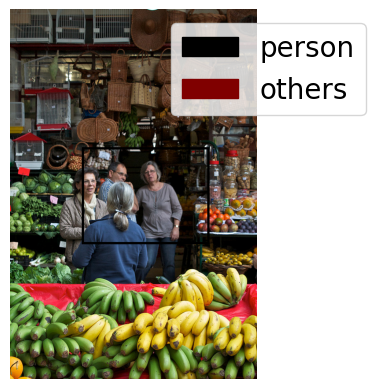

In [23]:
from PIL import Image, ImageDraw
img_copy_test = img.copy()

idx = best_id
#print((processed_new_bbox[i][j]))
topLeft = (prop_rects[idx][0],prop_rects[idx][1])
bottomRight = (prop_rects[idx][2],prop_rects[idx][3])
img2 = ImageDraw.Draw(img_copy_test)
#rect_color = getHexColor(rgba_cols[i])
draw_rectangle(img2, (topLeft,bottomRight),color = tuple(rgba_cols[i]), width=4)
#draw_rectangle(img1, (topLeft,bottomRight),color = "red", width=2)
plt.axis('off')
plt.imshow(img_copy_test)
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
#**TODO** IOU, remember to check for size difference
#plt.figure()
#refer.showRef(ref, seg_box='box')
#plt.show()

1. gray shirt wearing glasses
2. lady with glasses
3. woman with gray shirt standing next to man


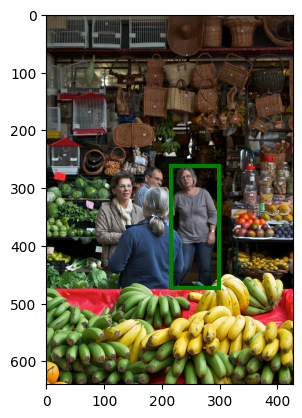

In [24]:
plt.figure()
refer.showRef(ref, seg_box='box')
plt.show()

In [26]:
new_bbox_xywh = [topLeft[0], topLeft[1], bottomRight[0]-topLeft[0], bottomRight[1]-topLeft[1]]
IoU = computeIoU(ref_bbox, new_bbox_xywh)
IoU

0.24455599168904119